## Fastmarch ORCA Policy

In [2]:
import numpy as np
from crowd_sim.envs.policy.orca import ORCA
from crowd_sim.envs.utils.state import JointState
import CMap2D
import matplotlib.pyplot as plt
from map2d import gridshow

class Suicide(object):
    def __init__(self):
        pass

class FastmarchORCAPolicy(object):
    def __init__(self, suicide_if_stuck=False):
        self.simulator = ORCA()
        self.suicide_if_stuck = suicide_if_stuck
        self.map = CMap2D.CMap2D()
        self.grid_num = 100
        self.new = True

    def reset(self):
        self.new = True
        self.simulator.reset()        
    
    def predict(self, obs, env):
        self.simulator.time_step = env._get_dt()
        other_agent_states = [
            agent.get_observable_state() for agent in env.soadrl_sim.humans + env.soadrl_sim.other_robots]
        joint_state = JointState(env.soadrl_sim.robot.get_full_state(), other_agent_states)
        
        if self.new:
            #find an appropriate origin
            bbox = env.soadrl_sim.obstacle_vertices[-1]
            bbox_ll = np.array(bbox[-1])
            bbox_tr = np.array(bbox[1])
            self.map.origin[0] = bbox_ll[0] - 0.25
            self.map.origin[1] = bbox_ll[1] - 0.25
            
            #find the right resolution
            max_dim = max(bbox_tr-bbox_ll)
            #offset = 2*max_dim/self.grid_num
            self.map.set_resolution((max_dim+2*0.25)/self.grid_num)
            
            #initialise occupancy
            self.map._occupancy = np.ones((self.grid_num,self.grid_num), dtype = np.float32)
            bbox_ij = self.map.xy_to_ij(bbox)
            self.map._occupancy[bbox_ij[-1,0]:bbox_ij[1,0], bbox_ij[-1,1]:bbox_ij[1,1]] = 0
            
            radius = env.soadrl_sim.robot.radius*1.05
            for vertex in env.soadrl_sim.obstacle_vertices[:-1]:
                xy_min, xy_max = np.min(vertex, 0), np.max(vertex,0)
                xy_min -= radius
                xy_max += radius
                min_max_ij = self.map.xy_to_ij([xy_min,xy_max])
                self.map._occupancy[min_max_ij[0,0]:min_max_ij[1,0], min_max_ij[0,1]:min_max_ij[1,1]] = 1
            #self.map.HUGE_ = 100 * np.prod( self.map._occupancy.shape )
            #calculate the field
            goal = self.map.xy_to_ij([(env.soadrl_sim.robot.gx,env.soadrl_sim.robot.gy)])
            self.field = self.map.fastmarch(goal[0])
            
            plt.figure("occupancy", figsize=[8,8]) 
            grid = self.map.occupancy()
            gridshow(self.field)
            
            self.new = False
        
            # only for vizualisation atm
            robot_pos_xy = (joint_state.self_state.px, joint_state.self_state.py)
            robot_pos_ij = self.map.xy_to_ij([robot_pos_xy])
            gridfmpath8, jumps = CMap2D.path_from_dijkstra_field(self.field, robot_pos_ij[0], connectedness= 8)
            plt.plot(gridfmpath8[:,0],  gridfmpath8[:,1] , '-o', color=plt.cm.winter(0.33) , mec=plt.cm.winter(0.33), mfc=[0,0,0,0])
            plt.show()
        robot_pos_xy = (joint_state.self_state.px, joint_state.self_state.py)
        robot_pos_ij = self.map.xy_to_ij([robot_pos_xy])
        gridfmpath8, jumps = CMap2D.path_from_dijkstra_field(self.field, robot_pos_ij[0], connectedness= 8) 
        
        if gridfmpath8.shape[0] > 15:
            virtual_goal = gridfmpath8[15]  # look forward in path
            virtual_goal[0] = (virtual_goal[0]*self.map.resolution())+self.map.origin[0]
            virtual_goal[1] = (virtual_goal[1]*self.map.resolution())+self.map.origin[1]
            print("vx: ", joint_state.self_state.vx,"vy: ", joint_state.self_state.vy, "v: ",
                  np.sqrt(joint_state.self_state.vx**2+joint_state.self_state.vy**2))
            joint_state.self_state.gx = virtual_goal[0]
            joint_state.self_state.gy = virtual_goal[1]
            
            if np.sqrt(joint_state.self_state.vx**2+joint_state.self_state.vy**2) < 0.25:
                virtual_goal = gridfmpath8[8]  # look forward in path
                virtual_goal[0] = (virtual_goal[0]*self.map.resolution())+self.map.origin[0]
                virtual_goal[1] = (virtual_goal[1]*self.map.resolution())+self.map.origin[1]
                idx = np.argmin([virtual_goal[0] - robot_pos_xy[0],virtual_goal[0] - robot_pos_xy[0]])
                print("idx: ", idx)
                if idx == 0:
                    joint_state.self_state.gx = robot_pos_xy[0] + np.sign(virtual_goal[0] - robot_pos_xy[0])#*(virtual_goal[1] - robot_pos_xy[1]) #virtual_goal[0]
                elif idx == 1:
                    joint_state.self_state.gy = robot_pos_xy[1] + np.sign(virtual_goal[1] - robot_pos_xy[1])#*(virtual_goal[0] - robot_pos_xy[0]) #virtual_goal[1]
            
        action = self.simulator.predict(
            joint_state,
            env.soadrl_sim.obstacle_vertices,
            env.soadrl_sim.robot,
        )
        if self.suicide_if_stuck:
            if action.v < 0.02:
                return Suicide()
        vx = action.v * np.cos(action.r)
        vy = action.v * np.sin(action.r)
        return np.array([vx, vy]) #, 0.1*(np.random.random()-0.5)

## Play Policy

In [3]:
import os

def play_policy(env, n_sequences, episode_length=1000,
                         subset_index=0, n_subsets=1,
                         render=True,
                         policy=FastmarchORCAPolicy(),
                         archive_dir=os.path.expanduser("~/navrep/datasets/V/ian")
                         ):
    """
    if n_subsets is None, the whole set of sequences is generated (n_sequences)
    if n_subsets is a number > 1, this function only generates a portion of the sequences
    """
    indices = np.arange(n_sequences)
    if n_subsets > 1:  # when multiprocessing
        indices = np.array_split(indices, n_subsets)[subset_index]
    scans = []
    robotstates = []
    actions = []
    rewards = []
    dones = []
    for n in indices:
        policy.reset()
        obs = env.reset()
        for i in range(episode_length):
            # step
            action = policy.predict(obs, env)
            if isinstance(action, Suicide):
                obs = env.reset()
                rew = 0
                action = np.array([0, 0, 0])
                done = True
            else:
                obs, rew, done, _ = env.step(action)
            scans.append(obs[0])
            robotstates.append(obs[1])
            actions.append(action)
            rewards.append(rew)
            dones.append(done)
            if render:
                env.render(save_to_file=True)
            if done:
                policy.reset()
                obs = env.reset()
        dones[-1] = True

    scans = np.array(scans)
    robotstates = np.array(robotstates)
    actions = np.array(actions)
    rewards = np.array(rewards)
    dones = np.array(dones)
    data = dict(scans=scans, robotstates=robotstates, actions=actions, rewards=rewards, dones=dones)
        #if archive_dir is not None:
         #   make_dir_if_not_exists(archive_dir)
          #  archive_path = os.path.join(
           #     archive_dir, "{:03}_scans_robotstates_actions_rewards_dones.npz".format(n)
            #)
            #np.savez_compressed(archive_path, **data)
            #print(archive_path, "written.")
    env.close()
    return data

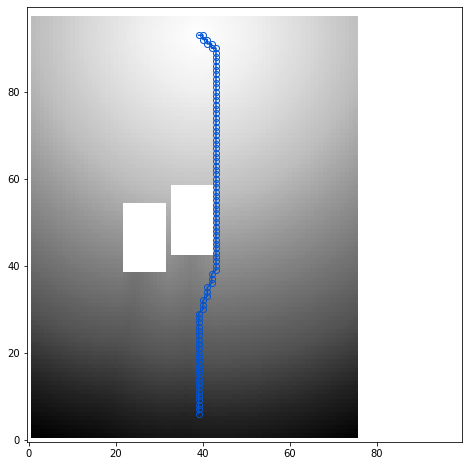

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.040965184569358826 vy:  0.5074011087417601 v:  0.5090520911450704
vx:  -0.04182461649179453 vy:  0.7751691341400146 v:  0.7762966475955346
vx:  -0.022528467699885535 vy:  0.9117479324340821 v:  0.9120262190061909
vx:  -0.0021053911186754704 vy:  0.9777441620826721 v:  0.9777464288651272
vx:  0.006383519619703237 vy:  0.9999796152114868 v:  0.9999999900806241
vx:  0.006383519619703237 vy:  0.9999796152114868 v:  0.9999999900806241
vx:  0.004773837048560381 vy:  0.9999886155128479 v:  1.0000000103377342
vx:  0.004773837048560381 vy:  0.9999886155128479 v:  1.0000000103377342
vx:  0.004773837048560381 vy:  0.9999886155128479 v:  1.0000000103377342
vx:  0.004773837514221613 vy:  0.9999886155128478 v:  1.0000000103399571
vx:  0.004773837514221613 vy:  0.9999886155128478 v:  1.0000000103399571
vx:  0.0027154625859110437 vy:  0.9950416088104248 v:  0.9950453140440861
vx:  -0.0017015686025843024 vy:  0.9719715714454651 v:  0.9719730608581064
vx:  -0.0

vx:  0.00934640318155287 vy:  0.07422255724668503 v:  0.07480871110151262
idx:  0
vx:  0.009498311206698414 vy:  0.07125364989042282 v:  0.07188393797286181
idx:  0
vx:  0.00965638458728791 vy:  0.06840351969003677 v:  0.06908174338624395
idx:  0
vx:  0.009815432131290415 vy:  0.06566738337278366 v:  0.0663968971184054
idx:  0
vx:  0.009973094798624516 vy:  0.06304068118333817 v:  0.06382468256028884
idx:  0
vx:  0.01012831833213566 vy:  0.06051904708147048 v:  0.06136071945378669
idx:  0
vx:  0.010280896909534935 vy:  0.05809829384088516 v:  0.05900092023423296
idx:  0
vx:  0.010431051254272447 vy:  0.055774353444576256 v:  0.05674138994093971
idx:  0
vx:  0.010579213500022881 vy:  0.053543396294116974 v:  0.054578521828535495
idx:  0
vx:  0.01072614453732968 vy:  0.05140165239572524 v:  0.05250885683050673
idx:  0
vx:  0.010872679762542265 vy:  0.04934558272361755 v:  0.05052921629663554
idx:  0
vx:  0.011019904166460029 vy:  0.047371760010719306 v:  0.04863663160983857
idx:  0
vx:  

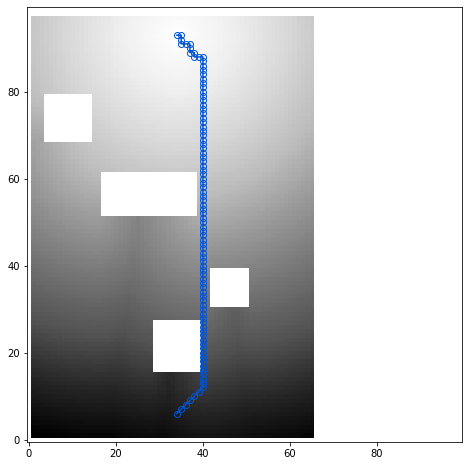

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.24253554642200476 vy:  0.4189381301403045 v:  0.48407917551127433
vx:  0.5056164860725403 vy:  0.7384968996047974 v:  0.8950003920190435
vx:  0.4610146284103395 vy:  0.8438682556152343 v:  0.9615862522121569
vx:  0.45907860994338995 vy:  0.8403243422508239 v:  0.9575479989467028
vx:  0.4568387269973756 vy:  0.8362243175506591 v:  0.9528760316786482
vx:  0.45423245429992687 vy:  0.8314540386199951 v:  0.9474402043806435
vx:  0.4511821866035462 vy:  0.825870394706726 v:  0.9410777196179922
vx:  0.4415507912635801 vy:  0.8082405328750611 v:  0.9209885234071359
vx:  0.4313227236270906 vy:  0.789518415927887 v:  0.8996547232168414
vx:  0.4140698313713074 vy:  0.7579376697540284 v:  0.8636685339202937
vx:  0.39750707149505604 vy:  0.7276202440261841 v:  0.8291218797048473
vx:  0.3816067576408386 vy:  0.6985154151916504 v:  0.7959569729184597
vx:  0.36634257435798656 vy:  0.6705747842788695 v:  0.7641187231693052
vx:  0.3516886234283449 vy:  0.6437518

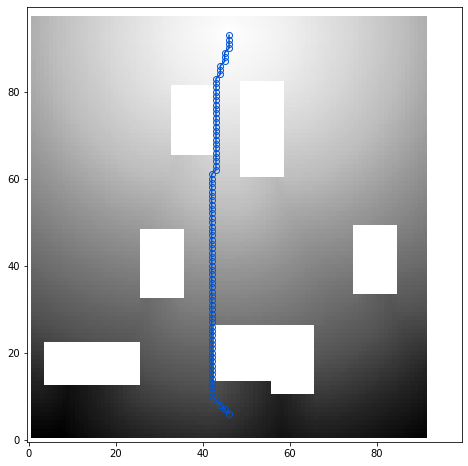

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.24882212281227115 vy:  0.3366633355617522 v:  0.4186342679623467
vx:  -0.30641859769821167 vy:  0.894569158554077 v:  0.9455931135808296
vx:  -0.32271206378936756 vy:  0.9421366453170777 v:  0.9958737543305929
vx:  -0.32255828380584717 vy:  0.9416878223419191 v:  0.9953993174595004
vx:  -0.3223765790462495 vy:  0.9411575794219971 v:  0.9948388050438299
vx:  -0.32215982675552374 vy:  0.9405249357223511 v:  0.9941700602465765
vx:  -0.3218985199928283 vy:  0.9397617578506471 v:  0.9933633870302003
vx:  -0.3189140856266021 vy:  0.9310487508773804 v:  0.9841534283440677
vx:  -0.31833454966545105 vy:  0.9293570518493652 v:  0.9823652148426517
vx:  -0.3176536560058594 vy:  0.9273687005043031 v:  0.9802635114340066
vx:  -0.315919578075409 vy:  0.922305703163147 v:  0.9749117857009482
vx:  -0.30328279733657837 vy:  0.8854173421859741 v:  0.9359189735249385
vx:  -0.12268896400928504 vy:  0.8521497249603271 v:  0.8609365456522524
vx:  -0.03036123514175412

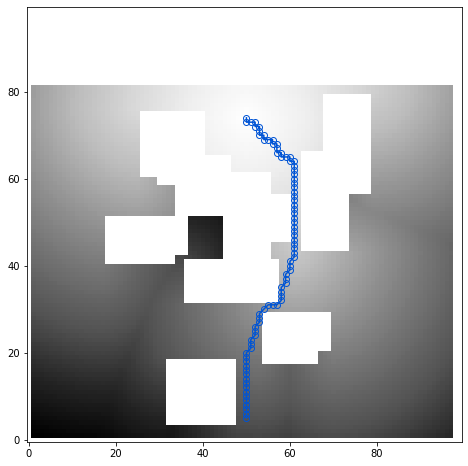

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.07622435688972473 vy:  0.1963316649198532 v:  0.2106092952209224
idx:  0
vx:  0.1936322152614594 vy:  0.23206257820129392 v:  0.3022357936917661
vx:  0.32500135898590105 vy:  0.40806880593299866 v:  0.5216761770660664
vx:  0.29011288285255427 vy:  0.44026085734367376 v:  0.5272524132766075
vx:  0.2746770977973938 vy:  0.4567362368106842 v:  0.5329685713720692
vx:  0.2510103881359101 vy:  0.4542582631111145 v:  0.5189959388635587
vx:  0.2132346630096434 vy:  0.43608790636062633 v:  0.48542938063412533
vx:  0.18457329273223866 vy:  0.41961658000946056 v:  0.45841615875627323
vx:  0.1674963384866714 vy:  0.4098025560379029 v:  0.4427111454906462
vx:  0.15256513655185702 vy:  0.3982582986354828 v:  0.42648070685919215
vx:  0.14393262565135947 vy:  0.3842873871326447 v:  0.4103576447882134
vx:  0.13704615831375117 vy:  0.36958846449851995 v:  0.394179251862565
vx:  0.13168895244598378 vy:  0.354660302400589 v:  0.3783198518386232
vx:  0.12717133760

vx:  -0.6529384851455688 vy:  0.7574109435081483 v:  1.0000000013650467
vx:  -0.6529384851455688 vy:  0.7574109435081483 v:  1.0000000013650467
vx:  -0.6529384851455688 vy:  0.7574109435081483 v:  1.0000000013650467
vx:  -0.6529384255409241 vy:  0.7574109435081484 v:  0.9999999624468815
vx:  -0.42729711532592785 vy:  0.8208886384963989 v:  0.9254409660147592


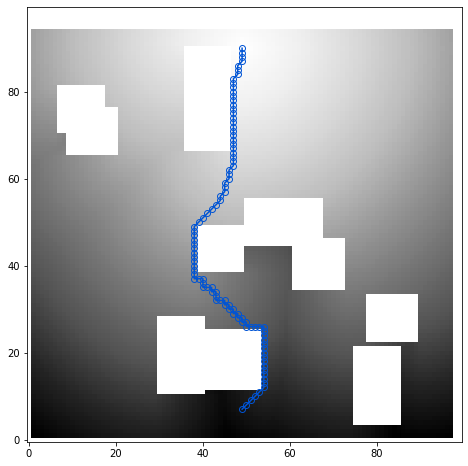

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.17785917222499847 vy:  0.18719981610774994 v:  0.2582201701946172
vx:  0.009763628244399955 vy:  0.2015509009361267 v:  0.20178724960873817
idx:  0
vx:  0.2674493491649628 vy:  0.1934889256954193 v:  0.33010167938913865
vx:  0.4136914014816286 vy:  0.5973777770996095 v:  0.7266366246152919
vx:  0.4565908908843995 vy:  0.6593255400657654 v:  0.8019884097801058
vx:  0.4483067989349365 vy:  0.6473633050918578 v:  0.7874377656365887
vx:  0.43744075298309326 vy:  0.6316725015640259 v:  0.7683518475298734
vx:  0.42557960748672496 vy:  0.6145447492599487 v:  0.7475180607527341
vx:  0.41269385814666754 vy:  0.5959377884864807 v:  0.7248848655463426
vx:  0.39877676963806147 vy:  0.575840711593628 v:  0.7004394600046626
vx:  0.3838484287261961 vy:  0.554284155368805 v:  0.6742184669144559
vx:  0.367962747812271 vy:  0.5313464403152466 v:  0.6463169682232092
vx:  0.3512101173400879 vy:  0.5071445107460023 v:  0.6168825668649102
vx:  -0.001095980405807634

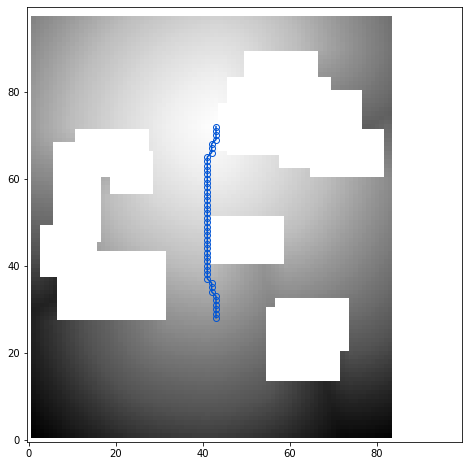

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.17403471469879153 vy:  0.4339422881603241 v:  0.46754036336353627
vx:  -0.34959879517555237 vy:  0.7711651921272278 v:  0.8467083743159872
vx:  -0.18668262660503393 vy:  0.8395497798919678 v:  0.8600547866228093
vx:  -0.08431724458932868 vy:  0.8653936386108397 v:  0.869491545377668
vx:  -0.03594118729233725 vy:  0.8820734024047852 v:  0.8828053331136695
vx:  -0.018164049834012985 vy:  0.895388662815094 v:  0.895572883803532
vx:  -0.010344986803829559 vy:  0.9033227562904357 v:  0.9033819905134932
vx:  -0.005169329699128644 vy:  0.9068738222122192 v:  0.9068885551066008
vx:  -0.0013274373486636404 vy:  0.9080719351768493 v:  0.9080729054132948
vx:  0.0018840422853828587 vy:  0.9079762101173401 v:  0.9079781648004435
vx:  0.004849107936024721 vy:  0.9071370363235473 v:  0.9071499967026643
vx:  0.00717400759458553 vy:  0.8975695967674256 v:  0.8975982661671124
vx:  0.0070246756076813854 vy:  0.8788866400718689 v:  0.878914712679343
vx:  0.0069047

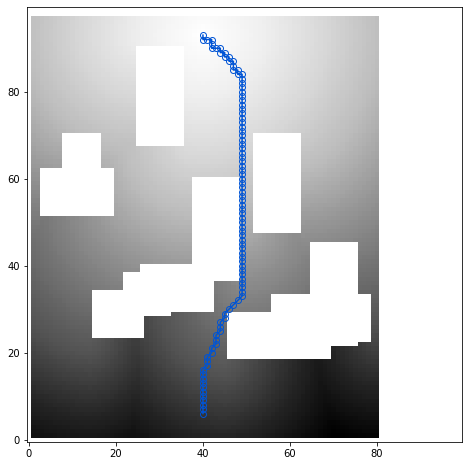

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.07538758218288424 vy:  0.6189991235733031 v:  0.6235729328089045
vx:  -0.020014904439449782 vy:  0.8929640650749204 v:  0.8931883440321235
vx:  0.005160152912139698 vy:  0.9557716250419616 v:  0.9557855546164258
vx:  0.005147159099579107 vy:  0.9175407290458679 v:  0.917555166028081
vx:  0.0051216185092923805 vy:  0.8808391094207764 v:  0.8808539990607644
vx:  0.005082815885543962 vy:  0.8456056118011476 v:  0.8456208877073221
vx:  0.0037655532360074406 vy:  0.8117814064025878 v:  0.8117901398589026
vx:  0.0037283897399903176 vy:  0.7793101668357849 v:  0.7793190854994327
vx:  0.003683418035507424 vy:  0.7481377720832824 v:  0.7481468395884338
vx:  0.27723583579063393 vy:  0.7182122468948365 v:  0.7698626762197665
vx:  0.3033681809902191 vy:  0.8517658710479735 v:  0.9041777216451572
vx:  0.3074870407581325 vy:  0.9287248253822328 v:  0.9783036755095282
vx:  0.2925699353218079 vy:  0.9079120755195618 v:  0.9538875740507606
vx:  0.26055693626403

vx:  -0.0027656615711748596 vy:  0.017254017293453213 v:  0.01747426669960877
idx:  0
vx:  -0.002689103595912454 vy:  0.01656389236450195 v:  0.016780757086983747
idx:  0
vx:  -0.0026136850938200903 vy:  0.01590132713317871 v:  0.016114699946509176
idx:  0
vx:  -0.002538151340559124 vy:  0.015265271067619322 v:  0.015474841291447147
idx:  0
vx:  -0.002463188255205752 vy:  0.014654681086540224 v:  0.014860248118008774
idx:  0
vx:  -0.0023894766345620186 vy:  0.01406845450401306 v:  0.014269933802180135
idx:  0
vx:  -0.0023161536082625324 vy:  0.013505741953849792 v:  0.013702906015186924
idx:  0
vx:  -0.0022441018372774185 vy:  0.01296548545360565 v:  0.013158259995293131
idx:  0
vx:  -0.0021729094441980176 vy:  0.012446880340576168 v:  0.012635124283730115
idx:  0
vx:  -0.002103643259033558 vy:  0.01194901019334793 v:  0.012132772130144456
idx:  0
vx:  -0.002036363352090123 vy:  0.011471033096313475 v:  0.011650380937911637
idx:  0
vx:  -0.0019703628495335523 vy:  0.01101221889257431 v

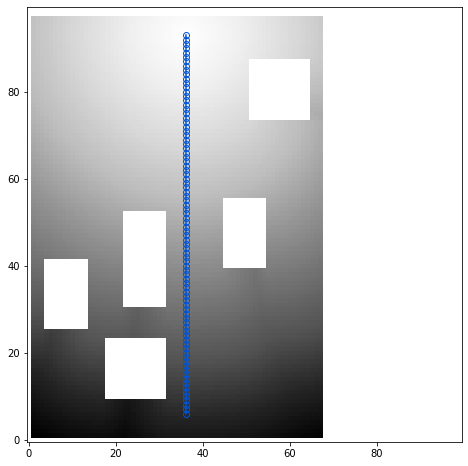

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.03750597685575474 vy:  0.3743293583393096 v:  0.3762036241380772
vx:  -0.07783355563878985 vy:  0.8204622268676758 v:  0.8241458172556857
vx:  0.006133266724646258 vy:  0.9999811649322509 v:  0.9999999735899883
vx:  0.006133266724646258 vy:  0.9999811649322509 v:  0.9999999735899883
vx:  0.006133266724646258 vy:  0.9999811649322509 v:  0.9999999735899883
vx:  0.006133266724646258 vy:  0.9999811649322509 v:  0.9999999735899883
vx:  0.004584913607686758 vy:  0.9999895095825195 v:  1.0000000203539388
vx:  0.004584913607686758 vy:  0.9999895095825195 v:  1.0000000203539388
vx:  0.004584913607686758 vy:  0.9999895095825195 v:  1.0000000203539388
vx:  0.004584913607686758 vy:  0.9999895095825195 v:  1.0000000203539388
vx:  0.004584913607686758 vy:  0.9999895095825195 v:  1.0000000203539388
vx:  0.0034274347126481697 vy:  0.999994099140167 v:  0.9999999728119314
vx:  0.0034274347126481697 vy:  0.999994099140167 v:  0.9999999728119314
vx:  0.0034274347

In [4]:
from navrep.envs.e2eenv import E2E1DNavRepEnv
env = E2E1DNavRepEnv(silent=True, scenario='train', adaptive=True, collect_statistics=False)
env.soadrl_sim.human_num = 7
env.soadrl_sim.num_walls = 7
env.soadrl_sim.num_circles = 7

data_reg = play_policy(env,1)

In [6]:
env.soadrl_sim.obstacle_vertices

[[(-1.9222712039705174, -5.322271203970518),
  (-4.077728796029483, -5.322271203970518),
  (-4.077728796029483, -7.477728796029483),
  (-1.9222712039705174, -7.477728796029483)],
 [(0.22671789043425028, 1.6267178904342505),
  (-0.8267178904342504, 1.6267178904342505),
  (-0.8267178904342504, 0.5732821095657498),
  (0.22671789043425028, 0.5732821095657498)],
 [(-1.2027019397565895, 2.697298060243411),
  (-3.197298060243411, 2.697298060243411),
  (-3.197298060243411, 0.7027019397565895),
  (-1.2027019397565895, 0.7027019397565895)],
 [(-1.013347616947582, -2.9133476169475823),
  (-1.986652383052418, -2.9133476169475823),
  (-1.986652383052418, -3.8866523830524184),
  (-1.013347616947582, -3.8866523830524184)],
 [(6.092999461024714, 1.0929994610247142),
  (4.7070005389752865, 1.0929994610247142),
  (4.7070005389752865, -0.2929994610247141),
  (6.092999461024714, -0.2929994610247141)],
 [(-1.280539896681852, 7.919460103318148),
  (-3.719460103318148, 7.919460103318148),
  (-3.7194601033181

[[22 10]]


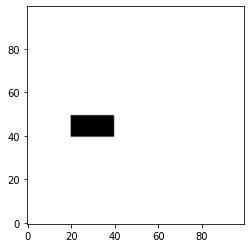

In [4]:
from map2d import gridshow

cmap2d = CMap2D.CMap2D()
cmap2d.set_resolution(0.1)
cmap2d.origin[0] = 0
cmap2d.origin[1] = 0
cmap2d._occupancy[20:40, 40:50] = 1.
coarse = cmap2d.as_coarse_map2d().as_coarse_map2d().as_coarse_map2d()

print(cmap2d.xy_to_ij([[2.26, 1.]]))

# occupancy
plt.figure("occupancy") 
grid = cmap2d.occupancy()
gridshow(grid)
plt.show()

In [5]:
env.reset()
i = 0
for vertex in env.soadrl_sim.obstacle_vertices:
    print(vertex)
    i+=1    
print(i)
env.render()

[(-1.9222712039705174, -5.322271203970518), (-4.077728796029483, -5.322271203970518), (-4.077728796029483, -7.477728796029483), (-1.9222712039705174, -7.477728796029483)]
[(0.22671789043425028, 1.6267178904342505), (-0.8267178904342504, 1.6267178904342505), (-0.8267178904342504, 0.5732821095657498), (0.22671789043425028, 0.5732821095657498)]
[(-1.2027019397565895, 2.697298060243411), (-3.197298060243411, 2.697298060243411), (-3.197298060243411, 0.7027019397565895), (-1.2027019397565895, 0.7027019397565895)]
[(-1.013347616947582, -2.9133476169475823), (-1.986652383052418, -2.9133476169475823), (-1.986652383052418, -3.8866523830524184), (-1.013347616947582, -3.8866523830524184)]
[(6.092999461024714, 1.0929994610247142), (4.7070005389752865, 1.0929994610247142), (4.7070005389752865, -0.2929994610247141), (6.092999461024714, -0.2929994610247141)]
[(-1.280539896681852, 7.919460103318148), (-3.719460103318148, 7.919460103318148), (-3.719460103318148, 5.480539896681853), (-1.280539896681852, 

ArgumentError: argument 2: <class 'TypeError'>: wrong type

In [ ]:
i

In [ ]:
import numpy as np
np.array((1,2))

In [ ]:
amap = CMap2D.CMap2D()
print(dir(env.soadrl_sim.robot))

In [ ]:
data = data_reg
print(data['rewards'][data['rewards']>2].size)
print(data['dones'][data['dones']==True].size)

In [ ]:
#177

#182

# 283 augmented

# 232 not augmented